# Data Wrangling with SQL Mountain View, Ca

## 1. Inspect, audit and improve the XML data with Python

##### Aviad Giat - Data Analyst Nano Degree Program, Udacity

I chose to do this project on the city of Mountain View, CA, where I currently live with my wife and two kids. I believe I will be able to learn more about my city using this dataset. I will be inspecting the OSM (XML) file to get a glimpse of how the dataset looks like, including sample lists of the street names, users contributing to the map in the city and what kind of street types we have in Mountain View. After inspecting, I will audit the OSM file, find issues with the street names and zip codes that will potentially make the analysis results inaccurate, correct the issues with Python before converting the clean data to the tabular format, CSV. CSV files will be used to create data structures (On another file called "Wrangle Openstreetmap Data - Analyze"), which will then be used in an SQL database. I will do my analysis of the city on this SQL database.
For now, let us start with inspecting the XML file.

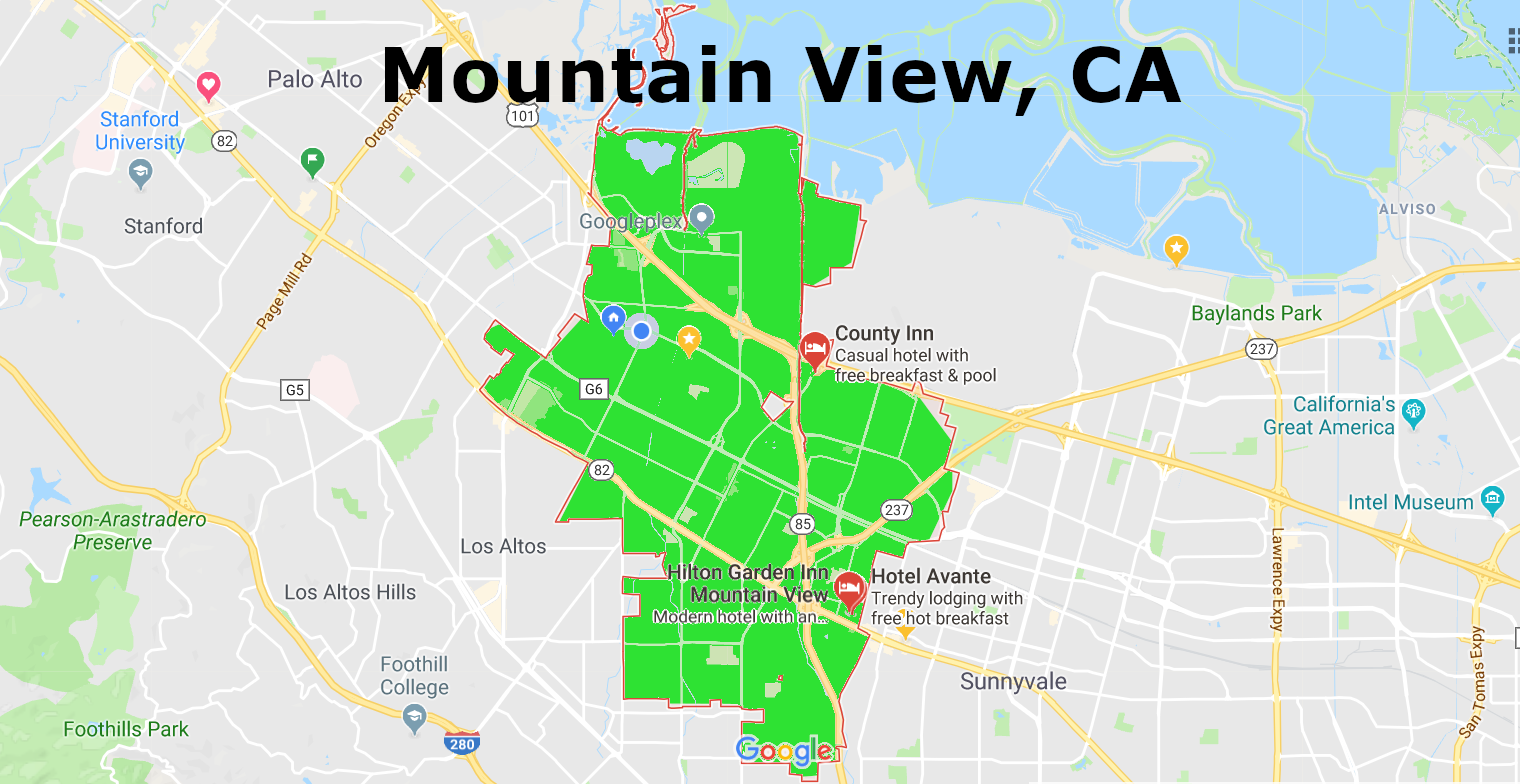

In [17]:
from IPython.display import Image
Image(filename='mountain_view_inverted.png')

<a id="top" name=""></a>
# Index
1. <a href="#inspect">Inspect the XML file</a>
2. <a href="#audit1">Audit the street names</a>
3. <a href="#problems1">Problems found and solutions for the wrong street names</a>
4. <a href="#improve1">Improve the street names</a>
5. <a href="#audit2">Audit the zip codes</a>
6. <a href="#problems2">Problems found and solutions for the zip codes</a>
7. <a href="#improve2">improve the zip codes</a>

#### Make the notebook cells look a bit better

In [3]:
%%html
<style>.output_wrapper, .output {height:auto !important; max-height:1000px;
                                }.output_scroll {box-shadow:none !important; webkit-box-shadow:none !important;}</style>

In [4]:
# Import relevant libraries for the inspection and audit of the XML file

import xml.etree.cElementTree as ET
import pprint
import re

<a id="inspect" name="inspect"></a><br />
# Inspect the Open Street Map file
<a href="#top">Top</a>

## Find all top level tags

In [5]:
# Parsing through the dataset and finding all top level tags

tree = ET.parse('mountain-view.osm')
root = tree.getroot()
tagslist = []
for elem in root.iter():
    tagslist.append(elem.tag)
tagslist = list(set(tagslist))
print(tagslist)

['bounds', 'note', 'relation', 'way', 'meta', 'member', 'tag', 'node', 'nd', 'osm']


## Count the number of appearences of each tag

In [6]:
# Count the tags

def count_tags(filename):
    tag_count = {} #create dictionary
    for _, element in ET.iterparse(filename, events=("start",)): #  iterate and parse and ignore the index
        add_tag(element.tag, tag_count)
    return tag_count

def add_tag(tag, tag_count):
    if tag in tag_count:
        tag_count[tag] += 1
    else:
        tag_count[tag] = 1

def execute():
    tags = count_tags('mountain-view.osm')
    pprint.pprint(tags)

if __name__ == "__main__":
     execute()

{'bounds': 1,
 'member': 10737,
 'meta': 1,
 'nd': 339312,
 'node': 291999,
 'note': 1,
 'osm': 1,
 'relation': 422,
 'tag': 111838,
 'way': 37291}


## Separate tags to types (lower, lower with colon ':', problemchars)
Checking the 'k' value of the tags. There are three regular expression, lower is for tags that contain only lowercase letters and are valid. lower_colon is for other valid tags with a colon in the value. problemchars is for tags with problematic characters. Finally I obtain a dictionary which contains the count of each of three tag categories above.

In [7]:
# Tag Types (lower, lower with colon ':', problematic charachters)

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        if re.search(problemchars, element.attrib['k']):
            keys['problemchars'] += 1
        elif re.search(lower_colon, element.attrib['k']):
            keys['lower_colon'] += 1
        elif re.search(lower, element.attrib['k']):
            keys['lower'] += 1
        else:
            keys['other'] += 1
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys

def keys():
    keys = process_map('mountain-view.osm')
    pprint.pprint(keys)


if __name__ == "__main__":
    keys()

{'lower': 70357, 'lower_colon': 39986, 'other': 1470, 'problemchars': 25}


## Find the number of contributing users and random 10 names

In [8]:
# Number of contributing users
import random
import itertools

def process_users(filename):
    users = []
    for _, element in ET.iterparse(filename):
        if "user" in element.attrib:
            users.append(element.attrib["user"])
    return users

def mv_users():
    users = process_users('mountain-view.osm')
    print('Number of users:')
    pprint.pprint(len(set(users))) # Set is bringing unique Ids, and len count occurrences
    
#     print('\n10 first names\n--------------') # Print the first 10 names instead of random names
#     for i, val in enumerate(itertools.islice(users, 10)):
#         print(i, val)

    print('\n10 random user names\n---------------------')
    count = 0
    random.shuffle(users)
    for elem in iter(users):
        count = count + 1
        if count == 10:
            break
        print(elem)
        
#     print('\nAll user\ns--------------\n')
#     print(users) # Show all users

if __name__ == "__main__":
    mv_users()

Number of users:
537

10 random user names
---------------------
AndrewBuck
dannykath
RichRico
RichRico
bdiscoe
calfarome
karitotp
matthieun
samely


## Find 20 random street names

In [9]:
# Find the number of streets and the names of the first 10
import random

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def process_map(filename):
    streets = []
    unique_streets = set()
    for _, element in ET.iterparse(filename):
        if element.tag == "tag":
            if element.attrib['k'] == "addr:street":
                streets.append(element.attrib["v"])
                unique_streets.add(element.attrib["v"])
    return streets
    return unique_streets


def mv_streets():
    streets = process_map('mountain-view.osm')
    unique_streets = process_map('mountain-view.osm')
    count = 0
    print('Number of times streets mentioned in the dataset:')
    pprint.pprint(len(streets))
    print('\nNumber of unique streets in the dataset:')
    pprint.pprint(len(set(unique_streets)))
    print('\n10 random street names\n---------------------')
    random.shuffle(streets)
    for elem in iter(streets):
        count = count + 1
        if count == 10:
            break
        print(elem)
        
if __name__ == "__main__":
    mv_streets()

Number of times streets mentioned in the dataset:
8404

Number of unique streets in the dataset:
452

10 random street names
---------------------
Radcliff Court
East El Camino Real
South Springer Road
Ruth Avenue
Cambridge Avenue
Peacock Avenue
South Whisman Road
Morgan Street
Alison Avenue


## Find all street type

In [10]:
# Find all street type

import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSM_FILE = "mountain-view.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = []

def audit_street_type(street_types, street_name):
    """Audit the type of a street name and add to a street_type set"""
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group() 
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    """Check if elem is a street name"""
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    """Return a dict of street_types and street_name from an osmfile"""
    osm_file = open(osmfile, "r", encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way": #only check way and node
            for tag in elem.iter("tag"): 
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

st_types = audit(OSM_FILE)
print('Number of street types:')
pprint.pprint(len(set(st_types)))

print('\nStreet Types (Correct and wrong):\n')
for i in enumerate(itertools.islice(st_types, 23)):
        print(i)


Number of street types:
23

Street Types (Correct and wrong):

(0, 'Road')
(1, 'Street')
(2, 'Avenue')
(3, 'Real')
(4, 'Lane')
(5, 'Boulevard')
(6, 'Way')
(7, 'Court')
(8, 'Drive')
(9, 'Corte')
(10, 'Parkway')
(11, 'Walk')
(12, 'C')
(13, 'Rd')
(14, 'Evelyn')
(15, 'Square')
(16, 'Place')
(17, 'Circle')
(18, 'Terrace')
(19, 'Alley')
(20, 'Corners')
(21, 'Bruno')
(22, 'B')


<a id="audit1" name=""></a>
# Audit the street names
<a href="#top">Top</a>

In [11]:
# Audit the type of a street name

import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint

OSM_FILE = "mountain-view.osm"

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Alley","Plaza","Commons","Broadway","Expressway","Terrace","Center","Circle",
            "Crescent","Highway","Way"] # Add values to the street names' suffix

def audit_street_type(street_types, street_name):
    """Audit the type of a street name and add to a street_type set"""
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group() 
        if street_type not in expected:
            street_types[street_type].add(street_name)

def is_street_name(elem):
    """Check if elem is a stre et name"""
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    """Return a dict of street_types and street_name from an osmfile"""
    osm_file = open(osmfile, "r", encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way": #only check way and node
            for tag in elem.iter("tag"): 
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

st_types = audit(OSM_FILE)
print('All street types that do not fall under the initial expected values (problematic, or Other)\n---------------')
pprint.pprint(st_types)

All street types that do not fall under the initial expected values (problematic, or Other)
---------------
defaultdict(<class 'set'>,
            {'B': {'Leghorn Street #B'},
             'Bruno': {'Serra San Bruno'},
             'C': {'Plymouth Street #C'},
             'Corners': {'Midrock Corners'},
             'Corte': {'Bella Corte'},
             'Evelyn': {'West Evelyn'},
             'Rd': {'E Middlefield Rd'},
             'Real': {'Easst El Camino Real',
                      'East El Camino Real',
                      'El Camino Real',
                      'W El Camino Real',
                      'W. El Camino Real',
                      'West El Camino Real'},
             'Walk': {'Altaire Walk'}})


<a id="problems1" name=""></a>
# Problems with street names
<a href="#top">Top</a>

#### The code Audit Street Name above 'thinks' that some suffixes of some street names are street types, while they are not.
'Bruno' is a part of a street name (San Bruno)<br />
'Real' is is part of a street name (El Camino Real)<br />
'Bella Corte' is a street name<br />
'Evelyn' is the steet name and not the type<br />

Solution: Include the correct street names in the 'expected' list for testing (so they dont come out as false/negative when auditing the file) and ignore them when creating the database, so we will not lose the records
when doing analysis of the new database.<br />


#### Over abbreviated street name 
'Rd' shuould be called 'Road'<br />

Solution: correct the street type from the 'Expected list' (i.e. 'St.' >> Street; 'Rd' >> Road, etc.)<br />


#### Misspelled street type
'Midrock Corners' is a wrong name and is called 'Midrock Cors' (after checking on Google)<br />

Solution:  Add <a href="https://www.expertmarket.com/postage-meters/usps-street-suffix-abbreviations">Cors</a> to the 'Expected' list and correct 'Corners' to 'Cors'.<br />


#### Wrong street type characters
'#B' is an error and should be removed<br />
'#C' is an error and should be removed<br />

Solution:  Remove all special charachters from the street type field and the charachters following them<br />


#### Streets that start with a short/misspelled form of the street direction 
'E Middlefield Rd' is shortspelled and should be 'East Middlefield Road'<br />
'W El Camino Real' is shortspelled<br />
'W. El Camino Real' is shortspelled followed by a '.' charachter<br />
'Easst El Camino Real' is misspelled<br />

Solution:  Change the wrong street initials to the full form ('W.' >> West, 'E' >> East, etc.)
Also, change the 'Easst El Cmino Real, to 'East El Camino Real.



## Other possible issues with the street names validity

Maybe there are more misspelled and missing charachters at the beginning of the street name that did not come up in the above auditing process...<br />
Those can be 'N', 'S', 'N.' or 'S.' and 'E.', which should be a full word like North, South, West and East.<br />

<a id="improve1" name=""></a>
# Improve street names
<a href="#top">Top</a>

In [12]:
# Improve the wrong street names found in the audit process above

from collections import defaultdict
import re
import pprint

OSMFILE = "mountain-view.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Alley","Plaza","Commons","Broadway","Expressway","Terrace","Center","Circle",
            "Crescent","Highway","Way", "Bruno", "Walk", "Corte"] 
            # Add new values to the street names' suffixes.

mapping = { "St": "Street",
            "St.": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Dr": "Drive",
            "Dr.": "Drive",
            "Ct": "Court",
            "Ct.": "Court",
            "Pl": "Place",
            "Pl.": "Place",
            "Sq": "Square",
            "Sq.": "Square",
            "Ln": "Lane",
            "Ln.": "Lane",
            "Rd.": "Road",
            "Rd" : "Road",
            "Tr" : "Trail",
            "Tr.": "Trail",
            "Pkwy": "Parkway",
            "Pkwy.": "Parkway",
            "Hwy": "Highway",
            "NE": "Northeast",
           'NW': 'Northwest',
           'SW': 'Southwest',
           'SE': 'Southeast',
           'E': 'East',
           'W': 'West',
           'S': 'South',
           'N': 'North',
           'Ter': 'Terrace',
           'Corners': 'Cors',
           'Easst': 'East',
           'W.' : 'West',
            '#C': '',
            '#B': ''
            }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type in expected:
            return fix_name(street_name, mapping)
        
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    """Return a dict of street_types and street_name from an osmfile"""
    osm_file = open(osmfile, "r", encoding="utf8")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way": #only check way and node
            for tag in elem.iter("tag"): 
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

def remv_special_chars():
    bad_types = audit(OSMFILE)
    for bad_type, ways in bad_type.items():
        for name in ways:
            if  st_wrong_char in name:
                street, rest = name.split()
                street.strip()
            return bad_types
        
def update_name(name, mapping):
    updated_names = []
    for i in name.split(' '):
        if i in mapping.keys():
            i = mapping[i]            
        updated_names.append(i)
    return " ".join(updated_names)

def fix_name(name, mapping):
    if "#" in name:
        street, *rest = name.split('#')
        name = street
    corrected_words = []
    words = name.split()  # Breaks a sentance into words on spaces
    for word in words:
        if word in mapping:
            correct_word = mapping[word]
        else:
            correct_word = word
        corrected_words.append(correct_word)
    name = " ".join(corrected_words)
    return name
    
def execute():
    st_types = audit(OSMFILE)
    pprint.pprint(st_types)
    
    for st_type, ways in st_types.items():
        for name in ways:
            better_name = fix_name(name, mapping)
            print(name, "=>", better_name)

if __name__ == '__main__':
    execute()

defaultdict(<class 'set'>, {})


<a id="audit2" name=""></a>
# Audit Zip Codes
<a href="#top">Top</a>

In [13]:
# Examine the wrong and correct zip code for Mountain view

osm_file = ('mountain-view.osm')

mountain_view_postals = ['94035', '94039', '94040', '94041','94042','94043'] # Mountain View official zipcodes

def audit_postal_code(error_codes, postal_codes, this_postal_code):
    if this_postal_code.isdigit() == False: # Find postal code that has no digits
        error_codes.append(this_postal_code) # Append to the error codes list
    elif len(this_postal_code) != 5: # Make sure the length of the postal code is not more than 5 digits
        error_codes.append(this_postal_code)
    elif this_postal_code not in mountain_view_postals: 
        error_codes.append(this_postal_code) # Append these results to the error codes object as well
    else:
        postal_codes.update([this_postal_code])

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode") # Make sure we chose the right tag with zip codes from the element tree

def audit_post(osmfile):
    osm_file = open(osmfile, "r", encoding="utf8") # Parse osm file for incorrect postal codes
    error_codes = []
    postal_codes = set([])
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(error_codes, postal_codes, tag.attrib["v"]) 
    return list(error_codes), postal_codes
wrong_zip_codes, correct_zip_codes = audit_post(osm_file)

print('Wrong zip codes for Mountain View, Ca:\n')
print(wrong_zip_codes)

print('\nMountain View zip codes found:\n')
print(correct_zip_codes)

Wrong zip codes for Mountain View, Ca:

['94022', '94087', '94087', '94087', '94306', '94086', '94087', '94087', '94086', '94024', '94087', '94087', '94087', '94086', '94086', '94303', '94087', 'CA 94035', 'CA 94085', '94024', '94087', '94087', '94087', '94035-0016', '94087', '94087', '94087', '94085', '94086', '94086', '94086', '94086', '94303', '94303', '94306', '9404', '94043-3421', '94807', '94087', '94087', '94086', '94086', '94086', '94024', '94024', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '94087', '30188', '94024', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94086', '94087', '94086', '94086', '94087', '94087']

Mountain View zip codes found:

{'94043', '94040', '

We can see from the above results that most of the wrong zip codes are coming from neighboring cities. This is simply because the downloaded OSM file's data was taken as a square, rather following the city's boundries. This is going to be fixed below, among other fixes.

<a id="problems2" name=""></a>
# Problems with Zip Codes
<a href="#top">Top</a>

#### Inaccurate zip codes that are not in Mountain View's city boundries
That is because the data is taken as a rectangle from the OSM map which includes pieces of data from the surounding cities.
There are only 6 zip codes allocated for Mountain View:
'94035', '94039', '94040', '94041','94042' and '94043'.

Solution: Check again the incorrect zip codes while doing the SQL analysis and make sure they are not in the MV city's bounderies, using external sources. In case they are not in MV, I will iterate and go back to correct them in the XML file. <br />

#### Too long zip codes 
Zip codes with more than 5 digits: 
'94035-0016'

Solution: Drop anything trailing the 5 digits zipcode<br />

#### Incomplete zip codes
Less than 5 digits:
'9404'

Solution: While doing the SQL analysis, search the address of the problematic entry on Google maps and find its zip code. After finding it, write it to the XML file.<br />

#### Ununiformed zip codes
'CA 94035' has letters in it.

Solution: Remove all what is not number from the zip codes.<br />

<a id="improve2" name=""></a>
# Improve Zip Codes
<a href="#top">Top</a>

In [16]:
def audit_post(osmfile):
    osm_file = open(osmfile, "r", encoding="utf8") # Parse osm file for incorrect postal codes
    error_codes = []
    postal_codes = set([])
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(error_codes, postal_codes, tag.attrib["v"]) 
    return list(set(error_codes)), list((postal_codes))
wrong_zip_codes, correct_zip_codes = audit_post(osm_file)

def audit_postal_code(error_codes, postal_codes, this_postal_code):
    if not this_postal_code.isdigit():        
        non_digits = re.sub("[^0-9]", "", str(this_postal_code))[:5] # Find postal code that has no digits, drop it 
        # and slice the string on the 5th charachter
        if len(non_digits) == 5 :
            if non_digits in mountain_view_postals:
                postal_codes.update([non_digits])
    else:
        if this_postal_code in mountain_view_postals:
            postal_codes.update([this_postal_code])

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")     # Make sure we chose the right tag with zip codes from the element tree

print("Wrong zip codes found")
print(wrong_zip_codes)

print("\nCorrect zip codes found")
print(correct_zip_codes)

Wrong zip codes found
[]

Correct zip codes found
['94043', '94035', '94040', '94041']


We can see from the above output that no wrong zip codes were found, and 4 different correct zip codes were found. So, our data set is clean from non-Mountain View related data. The dataset now is also clean from human errors done when inserting the zip codes.

Next, read the "Wrangle Openstreetmap Data - Inspect" file to see the SQL and Pandas analysis.